X_train shape:  (56000, 28, 28, 1)
56000 training samples
7000 validation samples
7000 test samples
One-hot encoding: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


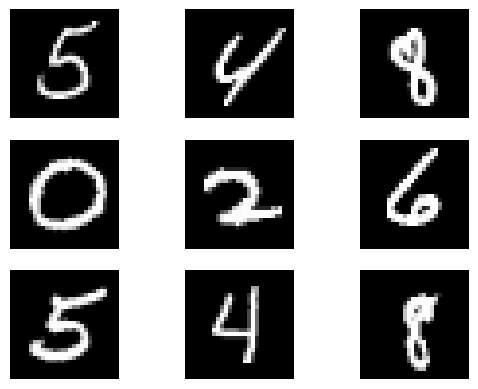

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

batch_size = 128 # Number of images processed at once
nb_classes = 10  # 10 Digits from 0 to 9

# Dimensionen of the input images (28x28 pixel)
img_rows, img_cols = 28, 28

# Load image data with labels
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Combine the initial training and test data so we can split it in custom proportions
X = np.concatenate([X, X_test], axis=0)
y = np.concatenate([y, y_test], axis=0)

# Splitting the data into 80% training and 20% (10% validation + 10% testing)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the remaining 20% equally into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing: Reshape and rescale data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype("float32") / 255.0
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1).astype("float32") / 255.0
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype("float32") / 255.0

print('X_train shape: ', X_train.shape)
print(X_train.shape[0], "training samples")
print(X_val.shape[0], "validation samples")
print(X_test.shape[0], "test samples")

# convert digit labels (0-9) in one-hot encoded binary vectors.
# These correspond to the training/test labels at the output of the net.
# Convert labels to one-hot encoding
Y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
Y_val = tf.keras.utils.to_categorical(y_val, nb_classes)
Y_test = tf.keras.utils.to_categorical(y_test, nb_classes)
print("One-hot encoding: {}".format(Y_train[0, :]))

# Show bitmaps of the first 9 trainings images
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.axis('off')

In [10]:
def residual_block(X, filters, downsample=False):
    X_shortcut = X

    if downsample:
        stride = 2
        X_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    else:
        stride = 1

    X = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(X)
    X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet18(input_shape, num_classes):
    X_input = Input(input_shape)

    X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = residual_block(X, 64)
    X = residual_block(X, 64)

    X = residual_block(X, 128, downsample=True)
    X = residual_block(X, 128)

    X = residual_block(X, 256, downsample=True)
    X = residual_block(X, 256)

    X = residual_block(X, 512, downsample=True)
    X = residual_block(X, 512)

    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation='softmax')(X)

    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    return model

model = ResNet18(input_shape=(img_rows, img_cols, 1), num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 14, 14, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 14, 14, 64)   0           ['batch_normalization_20[0]

In [12]:
nb_epoch = 30 # Number of passes over all pictures of the training set
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                 verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
438/438 [==============================] - 29s 31ms/step - loss: 0.1411 - accuracy: 0.9598 - val_loss: 1.1938 - val_accuracy: 0.7553
Epoch 2/30
438/438 [==============================] - 17s 39ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.3787 - val_accuracy: 0.9046
Epoch 3/30
438/438 [==============================] - 16s 36ms/step - loss: 0.0377 - accuracy: 0.9877 - val_loss: 0.0897 - val_accuracy: 0.9757
Epoch 4/30
438/438 [==============================] - 13s 30ms/step - loss: 0.0320 - accuracy: 0.9901 - val_loss: 0.0654 - val_accuracy: 0.9799
Epoch 5/30
438/438 [==============================] - 13s 30ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0438 - val_accuracy: 0.9884
Epoch 6/30
438/438 [==============================] - 13s 30ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.0418 - val_accuracy: 0.9879
Epoch 7/30
438/438 [==============================] - 13s 29ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0633 - val_accuracy:

In [13]:
score =  model.evaluate(X_test, Y_test, verbose=0)
print('Test score', score[0])
print('Test accuracy', score[1])

Test score 0.033015571534633636
Test accuracy 0.9932857155799866


In [14]:
# Make predictions using the test set
predictions = model.predict(X_test)

# Convert predictions from one-hot encoding to label encoding
predicted_labels = np.argmax(predictions, axis=1)

219/219 [==============================] - 1s 5ms/step


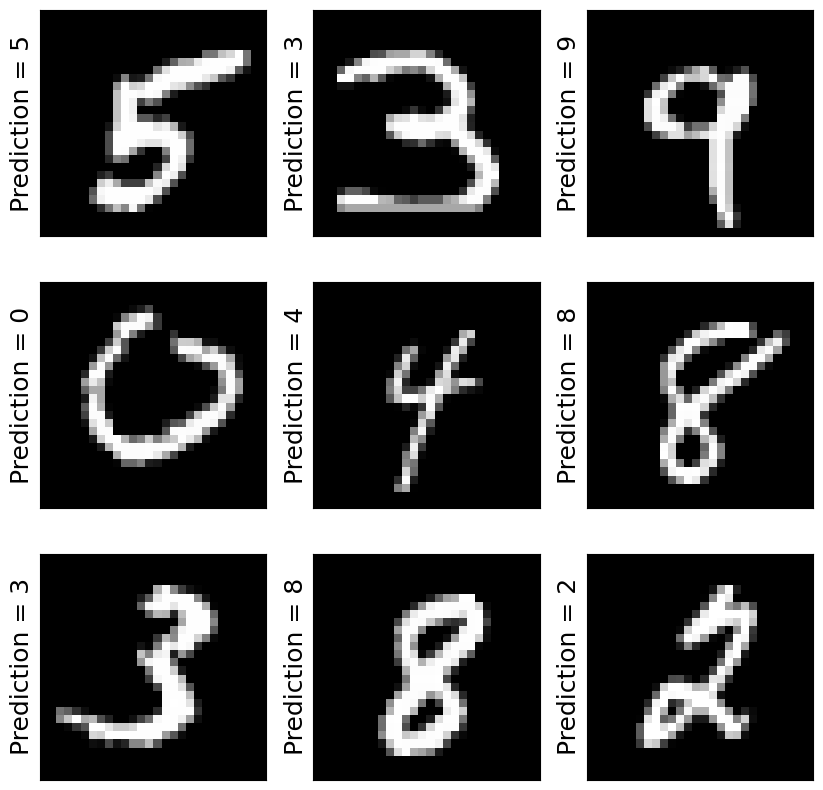

Test loss 0.0330, accuracy 99.33%


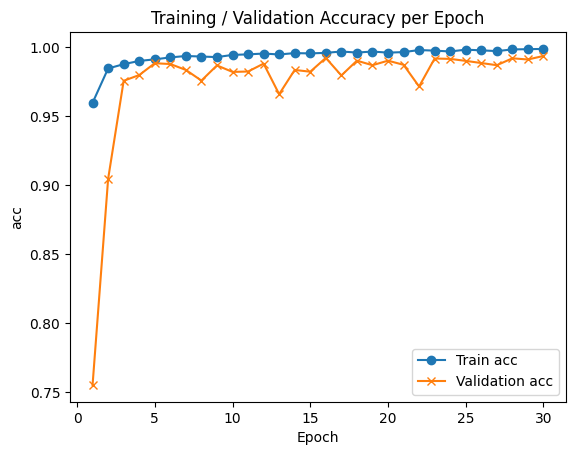

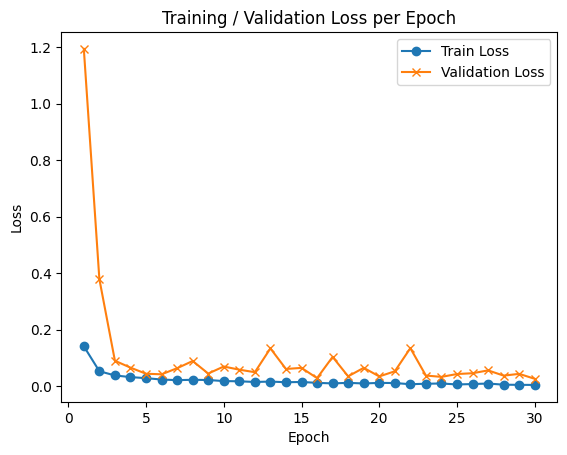

In [15]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel("Prediction = {}".format(res[i]), fontsize=18)

plt.savefig("Predictions.png")
plt.show()

test_score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

f, ax = plt.subplots()
ax.plot([None] + hist.history["accuracy"], "o-")
ax.plot([None] + hist.history["val_accuracy"], "x-")
# Plot legend and use the best location automatically: loc = 0.
ax.legend(["Train acc", "Validation acc"], loc = 0)
ax.set_title("Training / Validation Accuracy per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("acc")
plt.savefig("Training and Validation Accuracy per Epoch.png")

f, ax = plt.subplots()
ax.plot([None] + hist.history["loss"], "o-")
ax.plot([None] + hist.history["val_loss"], "x-")
# Plot legend and use the best location automatically: loc = 0.
ax.legend(["Train Loss", "Validation Loss"], loc = 0)
ax.set_title("Training / Validation Loss per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.savefig("Training and Validation Loss per Epoch.png")
plt.show()